In [2]:
import os
import sys
import glob
import json
import copy
import tqdm
import soxr
import numpy as np
import pandas as pd
import soundfile as sf

import IPython.display as ipd
import matplotlib.pyplot as plt

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_stimuli
import util_misc

sys.path.append('/om2/user/msaddler/spatial_audio_pipeline/generate_scenes')
import dataset_multitask

def parse_demographic_survey(raw_data):
    age = None
    gender = None
    hearing_loss = None
    for d in raw_data:
        if 'survey' in d['trial_type']:
            if age is None:
                age = d.get('response', {}).get('age', None)
            if gender is None:
                gender = d.get('response', {}).get('gender', None)
            if hearing_loss is None:
                hearing_loss = d.get('response', {}).get('hearing_loss', None)
                if isinstance(hearing_loss, str):
                    hearing_loss = True if 'yes' in hearing_loss.lower() else False
    return {'age': age, 'gender': gender, 'hearing_loss': hearing_loss}


In [ ]:
dir_dst = '/mindhive/mcdermott/www/msaddler/msjspsych/experiment_famous_voice_recognition/stim/v01_straight'
with open(os.path.join(dir_dst, 'config.json'), 'r') as f:
    CONFIG = json.load(f)
map_index_to_correct_response = {}
for k in CONFIG.keys():
    map_index_to_correct_response[CONFIG[k]['index_voice']] = CONFIG[k]['correct_response']
# for k in sorted(map_index_to_correct_response.keys()):
#     print(f'"{map_index_to_correct_response[k]}",')

dictionary = [
    "Al Pacino (actor known for role as Michael Corleone in The Godfather)",
    "Jennifer Aniston (actress known for role as Rachel Green in Friends)",
    "Arnold Schwarzenegger (former CA governor / Terminator actor)",
    "Betty White (actress known for role in Golden Girls)",
    "Beyonce (singer song-writer also known as Queen Bey)",
    "Bill Clinton (42nd US President)",
    "Bill O Reilly (television host and political commentator)",
    "Brad Pitt (actor known for Fight Club / Moneyball / Troy)",
    "Brian Williams (journalist and NBC news anchor)",
    "Charlie Sheen (actor known for Two and a Half Men)",
    "Conan O Brien (television host)",
    "Jason Alexander (actor known for role as George Costanza in Seinfeld)",
    "David Letterman (television host known for Late Night)",
    "Dolly Parton (country singer-songwriter)",
    "Julia Louis-Dreyfus (actress known for role of Elaine Benes in Seinfeld)",
    "Ellen DeGeneres (comedian and television host)",
    "Fran Drescher (actress known for role in The Nanny)",
    "Gordon Ramsay (celebrity chef)",
    "Gilbert Gottfried (actor known for voicing animated characters)",
    "Hillary Clinton (former US Secretary of State)",
    "George H W Bush (41st US President)",
    "James Earl Jones (actor known for role as Darth Vader)",
    "Jay Leno (television host and car enthusiast)",
    "Jon Stewart (comedian former host of The Daily Show)",
    "Margaret Thatcher (former UK Prime Minister)",
    "Matt Damon (actor known for role in Good Will Hunting)",
    "Morgan Freeman (actor known for Shawshank Redemption)",
    "Barack Obama (44th US President)",
    "Regis Philbin (television host and presenter)",
    "Robin Williams (actor known for Mrs Doubtfire / Alladin / Good Morning Vietnam)",
    "Rush Limbaugh (conservative political commentator)",
    "Jerry Seinfeld (comedian / actor / writer / producer)",
    "Alan Rickman (actor known for role as Professor Severus Snape)",
    "Sophia Vergara (actress known for role as Gloria in Modern Family)",
    "Stephen Colbert (comedian host of The Late Show)",
    "Alex Trebek (former Jeopardy host)",
    "Donald Trump (45th US President)",
    "George W Bush (43rd US President)",
    
    "Serena Williams (American tennis player)",
    "Taylor Swift (popular singer song-writer)",
    "LeBron James (American basketball player)",
    "Thierry Henry (French soccer player / commentator)",
    "Miley Cyrus (singer song-writer also known as Hannah Montana)",
    "Jim Carrey (comedy actor known for roles as Ace Ventura and Bruce Almighty)",
    "Tom Hanks (actor known for role as Forrest Gump)",
    "Kim Kardashian (American media personality / socialite / businesswoman / influencer)",
    "Vin Diesel (actor known for role as Dominic Toretto in Fast & Furious)",
    "Dwayne Johnson (actor and former professional wrestler known as The Rock)",
    "Harrison Ford (actor best known for role as Indiana Jones)",
    "Mark Hamill (actor best known for role as Luke Skywalker in Star Wars franchise)",
    "Leonardo DiCaprio (actor best known for role in Titanic)",
    "Adele (English singer-songwriter)",
    "Emma Watson (English actress known for role as Hermione in Harry Potter franchise)",
    "Anthony Hopkins (actor best known for role in The Silence of the Lambs)",
    "Charles Dance (English actor known for role as Tywin Lannister in Game of Thrones)",
    "David Attenborough (British broadcaster known for nature documentaries)",
    "Will Smith (American rapper and actor known for the Fresh Prince of Bel-Air)",
    "Sandra Oh (actress known for role as Cristina Yang in Greys Anatomy)",
    "Justin Bieber (Canadian singer-songwriter)",
    "Elton John (British singer / pianist / composer)",
    "Cristiano Ronaldo (Portuguese soccer player)",
    "Anderson Cooper (journalist and CNN news anchor)",
    "Erin Burnett (journalist and CNN news anchor)",
    "Sean Hannity (conservative political commentator on FOX news)",
    "Laura Ingraham (conservative television host on FOX news)",
    "Samuel L Jackson (actor known for roles in Pulp Fiction and Marvel movies)",
    "Kelly Ripa (American actress and talkshow host)",
    "Shia LeBeouf (filmmaker and actor known for role in Transformers)",
    "Eddie Murphy (actor known for role as Donkey in Shrek)",
    "Mike Myers (actor known for roles as Shrek and Austin Powers)",
    "Emilia Clarke (actress known for role as Daenerys Targaryen in Game of Thrones)",
    "Angela Merkel (former German politician and chancellor)",
    "Boris Johnson (former UK prime minister)",
    "Lewis Hamilton (British race car driver in Formula One)",
    "Jennifer Coolidge (actress known for role as Tanya McQuoid in The White Lotus)",
    "Matthew Mcconaughey (actor known for Interstellar and Lincoln car commericals)",
    "Jimmy Fallon (comedian and Tonight Show television host)",
    "Jimmy Kimmel (comedian and television host)",
    "John Oliver (comedian and television host of Last Week Tonight)",
    "Dave Chappelle (American comedian and actor known for Chappelles Show)",
    "Sarah Palin (US politician / former governor of Alaska and vice presidential candidate)",
    "Will Ferrel (comedy actor known for Anchorman / Elf / Step Brothers)",
    "Bob Ross (American painter and art instructor)",
    "Bill Nye (popular science communicator and educator known as the Science Guy)",
    "Walter Cronkite (longtime American broadcast journalist and CBS news anchor)",
    "Neil DeGrasse Tyson (American astrophysicist and science communicator)",
    "Hasan Minhaj (comedian and television host known for The Daily Show and Patriot Act)",
    "Sacha Baron Cohen (comedy actor known for Borat and The Dictator)",
    "Adam Sandler (comedy actor known for Happy Gilmore / 50 First Dates / Billy Madison)",
    "Chris Rock (American comedian and actor)",
    "Ricky Gervais (British comedian and actor)",
    "Rowen Atkinson (British comedian and actor known for character Mr Bean)",
    "Amy Schumer (American comedian and actor)",
    "Wanda Sykes (comedian / writer / and actor known for Black-ish)",
    "Steve Carrel (actor known for role as Michael Scott in The Office)",
    "Ellie Kemper (actress known for Erin in the The Office and Unbreakable Kimmy Schmidt)",
    "Mindy Kaling (comedian / writer / actress known for role as Kelly in The Office)",
    "Tina Fey (comedian and actress known for SNL and 30 Rock / Mean Girls / Sisters)",
    "Amy Poehler (comedian and actress known for SNL and role as Leslie Knope in Parks and Rec)",
    "Aubrey Plaza (actress known for role as April Ludgate in Parks an Rec)",
]
len(dictionary)

print("var dictionary = [")
for w in sorted(dictionary):
    assert all([_ not in w for _ in "',"])
    print(f'    "{w}",')
print("];")


In [3]:
fn_config = 'stim/v01_straight/config.json'
with open(fn_config, 'r') as f:
    CONFG = json.load(f)

regex_fn_data = 'data/v01_straight/subj_*.json'
list_fn_data = sorted(glob.glob(regex_fn_data))
list_df = []
for fn_data in list_fn_data:
    error_tag = False
    try:
        with open(fn_data, 'r') as f:
            raw_data = json.load(f)
    except:
        error_tag = True
        with open(fn_data, 'r') as f:
            raw_data = f.read()
        raw_data = json.loads(raw_data[:raw_data.rfind(',')] + '}]')
    demographic_data = parse_demographic_survey(raw_data)
    for d in raw_data:
        if d['trial_type'] == 'survey-multi-select':
            map_name_to_familiar_self_report = {
                k: True for k in d['response']['familiarity_self_report']
            }
    data = [d for d in raw_data if d.get('trial_type', '') == 'dictionary-text']
    print(fn_data, len(data), "<-- JSON ERROR" if error_tag else '')
    if len(data) > 75:
        df = pd.DataFrame(data)
        df['familiar_self_report'] = df['correct_response'].map(map_name_to_familiar_self_report)
        df['correct'] = df['correct_response'] == df['response']
        df_control = df[(df['control_trial'] == 1) & (df['correct'] == True)]
        map_name_to_familiar_control_trial = {
            k: True for k in df_control['correct_response'].values
        }
        df['familiar_control_trial'] = df['correct_response'].map(map_name_to_familiar_control_trial)
        for k, v in demographic_data.items():
            df[k] = v
        list_df.append(df)


data/v01_straight/subj_5589629dfdf99b72ead88339.json 76 
data/v01_straight/subj_559ffa9bfdf99b0ad674856a.json 0 
data/v01_straight/subj_55b1add5fdf99b6731f04c5a.json 76 
data/v01_straight/subj_55b2d3f2fdf99b525bc839aa.json 6 
data/v01_straight/subj_55bd8669fdf99b5bfc7d4cfc.json 0 
data/v01_straight/subj_55cc19c7fe3304000562562c.json 76 
data/v01_straight/subj_570d22b35e5156000efd8bd5.json 0 
data/v01_straight/subj_5720a9f6fd3a5200113c1891.json 76 
data/v01_straight/subj_5781c15381f331000139a89e.json 0 
data/v01_straight/subj_57bf2f693aa21900017f7ae6.json 76 
data/v01_straight/subj_57d70b2247180e0001f100e3.json 76 
data/v01_straight/subj_58595b56a3149800011e156e.json 9 
data/v01_straight/subj_58f0fca0d40252000192f201.json 76 
data/v01_straight/subj_59894fbbda239a0001fb8e16.json 76 
data/v01_straight/subj_599ec7dc617ca80001fcd124.json 76 
data/v01_straight/subj_59dc458f77860e000151240e.json 76 
data/v01_straight/subj_59f226a9d6380600018b2923.json 67 <-- JSON ERROR
data/v01_straight/subj_

data/v01_straight/subj_639fdcf5efa9e98ed809d0df.json 76 
data/v01_straight/subj_63a3a7777f64f5e056a3dd79.json 76 
data/v01_straight/subj_63acbbe336a9ca92853dca4a.json 30 
data/v01_straight/subj_63ae31ff5c725a41082afc56.json 76 
data/v01_straight/subj_63b5681c49af1cbe651420bc.json 76 
data/v01_straight/subj_63bc9e8cd8106f8d94c636d4.json 6 
data/v01_straight/subj_63bdca370b6ae7fa1786ce11.json 0 
data/v01_straight/subj_63cd760c18f08aa16c2c8a8a.json 0 
data/v01_straight/subj_63d042c98e64ec1173d30ab7.json 0 
data/v01_straight/subj_63d13f2f59ef764f641406dd.json 0 
data/v01_straight/subj_63d15e1be853005ff591b935.json 76 
data/v01_straight/subj_63d1650b103325686e22e3b7.json 0 
data/v01_straight/subj_63d193c45e01ccb694993e7f.json 0 
data/v01_straight/subj_63d3fa0d6c990bc96e11becf.json 0 
data/v01_straight/subj_63d42387aba51e699ab9ce5c.json 76 
data/v01_straight/subj_63d4393f67ae4bf53fce7c48.json 76 
data/v01_straight/subj_63d77a647dbf6c0c53b0d375.json 0 
data/v01_straight/subj_63d7a6a997f031985

In [69]:
df = pd.concat(list_df)
df['condition'] = df['stimulus'].map(
    lambda _: CONFG[_.replace('stim/v01_straight/', '')]['condition'])

df_results = util_misc.flatten_columns(df[
    (df.familiar_control_trial == True) &
    (df.familiar_self_report == True) &
    (df.control_trial == 0)
].groupby(['id_subject', 'condition']).agg({
    'correct': ['mean', 'sum', 'count'],
    'age': 'first',
    'gender': 'first',
    'hearing_loss': 'first',
}).reset_index()).rename(columns={
    'id_subject': 'participant_id',
    'age/first': 'participant_age',
    'gender/first': 'participant_gender',
    'hearing_loss/first': 'participant_hearing_loss',
})
df_results = df_results[df_results['participant_hearing_loss'] == False]

df_results_to_plot = util_misc.flatten_columns(df_results.groupby('condition').agg({
    'correct/mean': ['mean', 'count', 'sem'],
}).reset_index()).rename(columns={
    'correct/mean/mean': 'mean',
    'correct/mean/count': 'n',
    'correct/mean/sem': 'sem',
})

fn_results = 'data/v01_straight/combined_results.csv'
df_results.sort_index(axis=1).to_csv(fn_results, index=False)
print(f'Wrote: {fn_results}')

fn_results_to_plot = 'data/v01_straight/combined_results_to_plot.csv'
df_results_to_plot.sort_index(axis=1).to_csv(fn_results_to_plot, index=False)
print(f'Wrote: {fn_results_to_plot}')

df_results_to_plot


Wrote: data/v01_straight/combined_results.csv
Wrote: data/v01_straight/combined_results_to_plot.csv


,condition,mean,n,sem
0,harmonic_shift+00,0.795788,91,0.031218
1,harmonic_shift+03,0.691486,92,0.036127
2,harmonic_shift+06,0.528544,87,0.041016
3,harmonic_shift+12,0.315399,92,0.038349
4,harmonic_shift-03,0.684386,95,0.036862
5,harmonic_shift-06,0.550562,89,0.039951
6,harmonic_shift-12,0.350766,87,0.039097
7,inharmonic,0.631522,92,0.039597


[87 89 95 91 92 87 92 92]


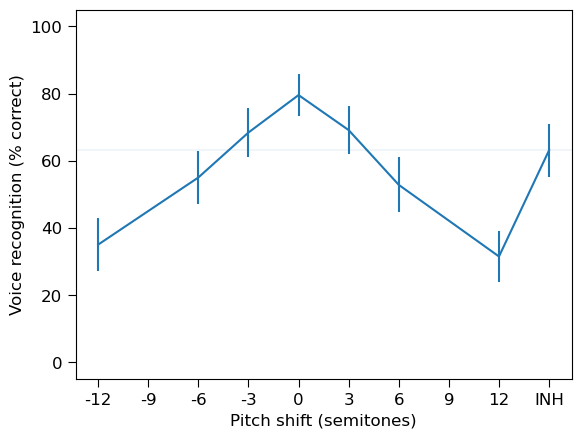

In [70]:
map_condition_to_x = {
    'harmonic_shift-12': -12,
    'harmonic_shift-06': -6,
    'harmonic_shift-03': -3,
    'harmonic_shift+00': 0,
    'harmonic_shift+03': 3,
    'harmonic_shift+06': 6,
    'harmonic_shift+12': 12,
    'inharmonic': 15,
}
x = df_results_to_plot['condition'].map(map_condition_to_x).values
IDX = np.argsort(x)
x = x[IDX]
y = 100 * df_results_to_plot['mean'].values[IDX]
yerr = 2 * 100 * df_results_to_plot['sem'].values[IDX]
n = df_results_to_plot['n'].values[IDX]
print(n)

fig, ax = plt.subplots()
ax.errorbar(x, y, yerr=yerr)
ax.axhline(y[-1], lw=0.1)
util_figures.format_axes(
    ax,
    ylimits=[-5, 105],
    xticks=[-12, -9, -6, -3, 0, 3, 6, 9, 12, 15],
    xticklabels=[-12, -9, -6, -3, 0, 3, 6, 9, 12, 'INH'],
    str_ylabel='Voice recognition (% correct)',
    str_xlabel='Pitch shift (semitones)')
plt.show()
